<a href="https://colab.research.google.com/github/Vatsal-Founder/Machine-Learning/blob/main/Mood_Recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Step 1: Download images of Happy, Sad and Angry person

In [1]:
# Skip this cell if you already have duckduckgo_search installed
!pip install -Uqq duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.9/76.9 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 38.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 6.4 MB/s eta 0:00:00


In [2]:

from duckduckgo_search import ddg_images
from fastcore.all import *

def search_images(term, max_images=200): return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [5]:
#NB: `search_images` depends on duckduckgo.com, which doesn't always return correct responses.
#    If you get a JSON error, just try running it again (it may take a couple of tries).
urls = search_images('happy people photos', max_images=1)
urls[0]

/usr/local/lib/python3.10/dist-packages/duckduckgo_search/compat.py:40: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")


'https://2.bp.blogspot.com/-tyytYhtXw1c/V32TnZ6LCUI/AAAAAAAAAbM/9Jhj1uWElnIGy3pEU-TnNuGBzG-JfQSSgCLcB/s1600/happy-people-pics-1600x1066.jpg'

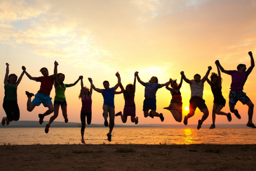

In [6]:
from fastdownload import download_url
dest = 'num.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

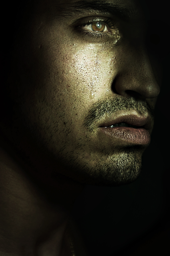

In [7]:
download_url(search_images('sad people photos', max_images=1)[0], 'nothappy.jpg', show_progress=False)
Image.open('nothappy.jpg').to_thumb(256,256)

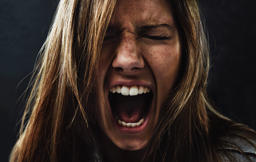

In [8]:
download_url(search_images('Anger people photos', max_images=1)[0], 'anger.jpg', show_progress=False)
Image.open('anger.jpg').to_thumb(256,256)

Downloading 200 images of each mood after satisfying with the image it has fetch from internet

In [9]:
searches = 'happy','sad', 'anger'
path = Path('happy_sad_anger')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} people photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} men photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} women photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## **Step 2: Train our model**

Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [10]:

failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

10

In [13]:
files = get_image_files(path)
len(files)

759

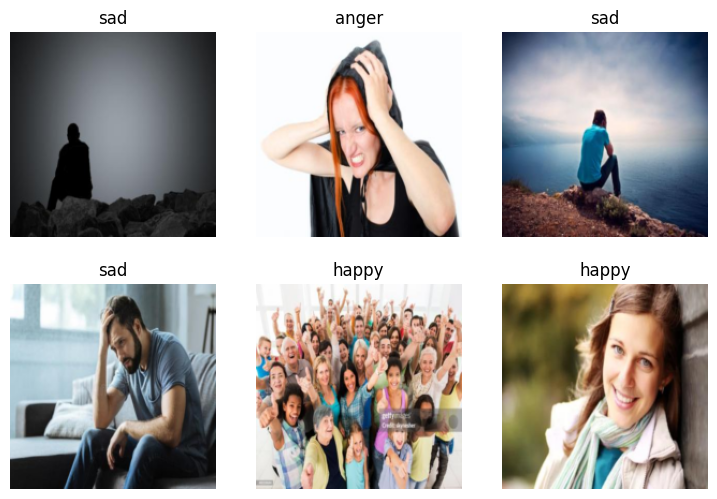

In [16]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path)

dls.show_batch(max_n=6)

Here what each of the DataBlock parameters means:

blocks=(ImageBlock, CategoryBlock),

The inputs to our model are images, and the outputs are categories (in this case, "bird" or "forest").

get_items=get_image_files,

To find all the inputs to our model, run the get_image_files function (which returns a list of all image files in a path).

splitter=RandomSplitter(valid_pct=0.2, seed=42),

Split the data into training and validation sets randomly, using 20% of the data for the validation set.

get_y=parent_label,

The labels (y values) is the name of the parent of each file (i.e. the name of the folder they're in, which will be bird or forest).

item_tfms=[Resize(192, method='squish')]

Before training, resize each image to 192x192 pixels by "squishing" it (as opposed to cropping it).

In [17]:

learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 48.7MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.613267,0.919622,0.370861,01:33


epoch,train_loss,valid_loss,error_rate,time
0,0.856659,0.726894,0.284768,02:14
1,0.598183,0.732743,0.245033,02:16
2,0.430835,0.683138,0.258278,02:17
3,0.328046,0.667902,0.251656,02:16


In [18]:
from urllib.request import urlopen

learn.predict(PILImage.create(urlopen(url)))

NameError: ignored

In [ ]:

is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")